In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 50)

In [2]:
# Datensatz einlesen
original_dms_data = pd.read_csv('/Users/liza/Desktop/Bioinfo Project/DMS_data/GFP_AEQVI_Sarkisyan_2016.csv')
# split first column of df into multiple columns
original_dms_data_col = original_dms_data
only_mutants = original_dms_data["mutant"].to_frame()
original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)

/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_61364/1912877112.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  original_dms_data_col[['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']] = original_dms_data_col['mutant'].str.split(':', 15, expand=True)


In [3]:
# zählen wieviele Mutationen jede Sequenz hat
list_mut_count_in_progress = []
for i in range(len(original_dms_data['mutant'])):
    list_mut_count_in_progress.append(original_dms_data['mutant'].iloc[i].count(':'))
list_mut_count_prae = np.array(list_mut_count_in_progress)
list_mut_count = (list_mut_count_prae + 1)
df_mutation_counts = pd.DataFrame(list_mut_count)

In [4]:
#zusammenfügen
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
#alle Spalten löschen die stören
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)
working_dataframe.head()

,DMS_score,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13,m14,m15,mut_count
0,1.301030,K3R,V55A,Q94R,A110T,D117G,M153K,D216A,None,None,None,None,None,None,None,None,7
1,3.137350,K3Q,V16A,I167T,L195Q,None,None,None,None,None,None,None,None,None,None,None,4
2,1.553913,K3Q,Y143C,N164D,S205P,A227T,None,None,None,None,None,None,None,None,None,None,5
3,3.404237,K3Q,Y143N,V193A,None,None,None,None,None,None,None,None,None,None,None,None,3
4,3.738586,K3R,None,None,None,None,None,None,None,None,None,None,None,None,None,None,1


In [5]:
#alle möglichen Mutationen rausschreiben in den Spalten
from pandas import unique
working_dataframe_only_ms = working_dataframe.loc[:, ["m1", "m2", "m3", 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15']]
all_possible_mutations = working_dataframe_only_ms.values.flatten().tolist()
all_possible_mutations = list(set(all_possible_mutations))
#hat einen none Wert, weil der auch ein Wert in der Liste ist -> wegmachen
while None in all_possible_mutations:
    all_possible_mutations.remove(None)
only_mutants_list = only_mutants['mutant']


In [6]:
#zusammenfügen
working_dataframe_prae = pd.concat([original_dms_data_col, df_mutation_counts], axis="columns")
#alle Spalten löschen die stören
working_dataframe = working_dataframe_prae.drop(['mutant', 'mutated_sequence', 'DMS_score_bin'], axis=1)
working_dataframe.rename(columns={working_dataframe.columns[16]: 'mut_count'}, inplace=True)


In [7]:
list_of_dfs = []

# For-Loop zum Erstellen und Hinzufügen eines neuen Columns in jedem Durchlauf
for i in all_possible_mutations:
    new_column_name = f'{i}'
    new_column_values = [only_mutants_list.str.contains(i, regex= False)]
    new_df = pd.DataFrame({new_column_name: new_column_values})
    new_df_exploded = new_df.explode(new_column_name)
    list_of_dfs.append(new_df_exploded)

# Verketten der DataFrames in der Liste
result_how_often = pd.concat(list_of_dfs, axis=1)
result_how_often = result_how_often.reset_index(drop=True)

## result_how_often.to_csv('dataframe_mutanten_Mutationen.csv', index=True)

In [8]:
# dataframe aus original machen der nur mutcount und fscore hat
count_fscore_frame = working_dataframe[['DMS_score', 'mut_count']]

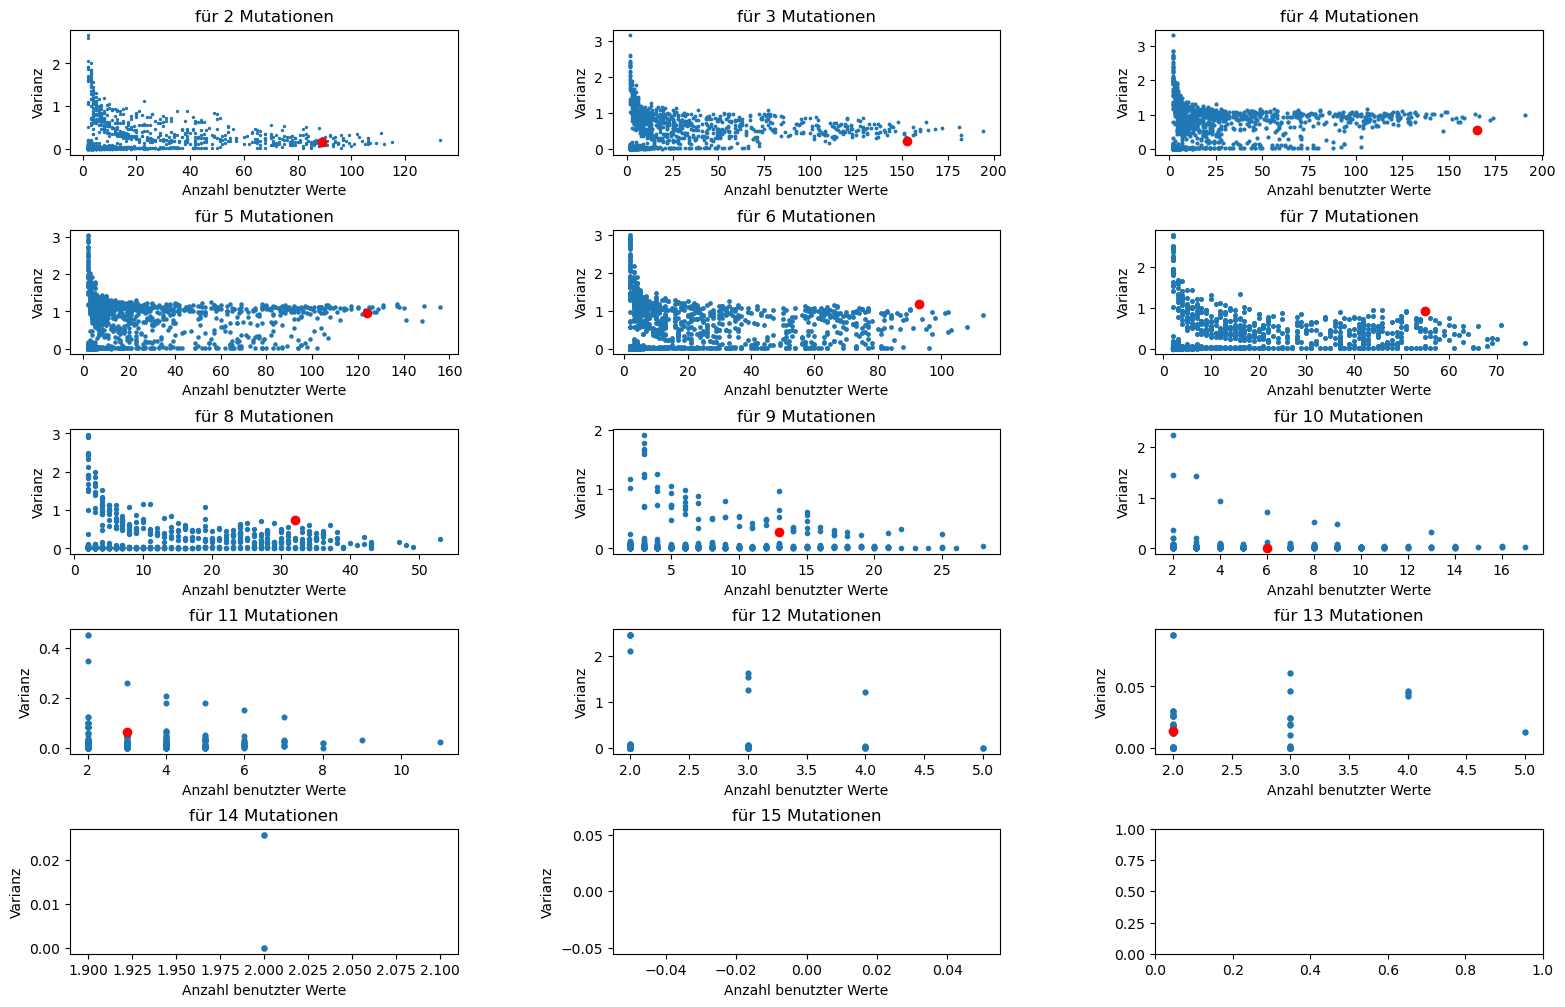

In [9]:
#verallgemeinert
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(19, 12))  # Abbildung und Achsenobjekte erstellen
plt.subplots_adjust(wspace=0.4, hspace=0.6)

for j, ax in zip(range(2, 16), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()
        variance_per_mutant_list.append(varianz_mut)

    variance_per_mutant_series = pd.Series(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_df = variance_per_mutant_series.to_frame()


#rausfinden wie viele Daten wir jeweils haben zum berechnen
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_for_variance = pd.Series(how_many_for_variance, index=all_possible_mutations)
    how_many_for_variance_df = how_many_for_variance.to_frame()


    how_many_AND_variance_df = pd.concat([how_many_for_variance_df, variance_per_mutant_df], axis = 1)
    how_many_AND_variance_df.columns = ['Anzahl benutzter Werte', 'Varianz']
    how_many_AND_variance_df = how_many_AND_variance_df.dropna()

#scatter plot erstellen, mit benennungen
    ax.scatter(how_many_AND_variance_df['Anzahl benutzter Werte'],how_many_AND_variance_df['Varianz'], s = j )
    ax.set_xlabel('Anzahl benutzter Werte')
    ax.set_ylabel('Varianz')

    if "V163A" in how_many_AND_variance_df.index:
        ax.scatter(how_many_AND_variance_df['Anzahl benutzter Werte']['V163A'],how_many_AND_variance_df['Varianz']['V163A'], c='red')
    ax.set_title(f'für {j} Mutationen')



VORBEREITUNG RANKINGS: Definitionen etc


In [10]:
#Varianzen mitteln für jede Mutation, über die Mutationscounts hinweg
frame_zum_mitteln_variance = pd.DataFrame(index = all_possible_mutations)
variance_per_mutant_count_list = []

# ACHTUNG: es werden nur counts von 2 bis 7 einbezogen weil die mit mehr sowieso "kaputt" sind!!!
for j, ax in zip(range(2, 8), axes.flatten()):
    variance_per_mutant_list = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        varianz_mut = fscore_mut.var()  #die varianz je mutation je anzahl
        variance_per_mutant_list.append(varianz_mut) #liste der Varianzen ALLER Mutationen je anzahl

    variance_per_mutant_df = pd.DataFrame(variance_per_mutant_list, index=all_possible_mutations)
    variance_per_mutant_count_list.append(variance_per_mutant_df)
variance_per_mutant_count_df = pd.concat(variance_per_mutant_count_list, axis=1)
variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

# Varianz je Mutation je Mutationanzahl
variance_per_mutant_count_df
# dataframe mit allen varianzen (Zellen) pro alle mutationen (rows) pro alle counts (columns)
mean_variances_per_mutations = pd.DataFrame(variance_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_61364/1098898036.py:18: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  variance_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [11]:
print(mean_variances_per_mutations)

           Mean
I188Y       NaN
K85Q   0.577271
K85T        NaN
V93D   0.346167
D197F       NaN
...         ...
K166I       NaN
V29Q        NaN
P54S   0.649659
T118K  1.475917
A110T  0.111496

[1810 rows x 1 columns]


In [12]:
how_many_per_mutant_count_list = []

for j, ax in zip(range(2, 8), axes.flatten()):
    how_many_for_variance = []

    for i in all_possible_mutations:
        mut_count_fscore = count_fscore_frame.loc[result_how_often[i] == True]
        fscore_mut = mut_count_fscore['DMS_score'].loc[mut_count_fscore['mut_count'] == j]
        wie_viel_jeweils = len(fscore_mut)
        how_many_for_variance.append(wie_viel_jeweils)

    how_many_per_mutant_df = pd.DataFrame(how_many_for_variance, index=all_possible_mutations)
    how_many_per_mutant_count_list.append(how_many_per_mutant_df)
how_many_per_mutant_count_df = pd.concat(how_many_per_mutant_count_list, axis=1)
how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)

mean_how_many_per_mutations = pd.DataFrame(how_many_per_mutant_count_df.mean(axis=1, skipna=True), columns=['Mean'])


/var/folders/sk/q8h0c3zs1v9dt93y5m134swr0000gn/T/ipykernel_61364/2598593114.py:15: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  how_many_per_mutant_count_df.set_axis(range(2,8), axis=1, inplace=True)


In [ ]:
combined_means_variance_how_many = pd.concat([mean_variances_per_mutations, mean_how_many_per_mutations], axis=1)
combined_means_variance_how_many.columns = ['mean_variances_per_mutations', 'mean_how_many_per_mutations']

----------------RANKING 0: nur nach Varianz der fscores

In [13]:
sorted_Ranking0 = combined_means_variance_how_many.sort_values(by='mean_variances_per_mutations')

# Ausgabe des sortierten DataFrames
sorted_Ranking0

NameError: name 'combined_means_variance_how_many' is not defined

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking0= sorted_Ranking0.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking0.html', 'w') as file:
    file.write(styled_ranking0.render())

----------------RANKING 1: nur nach Anzahl der Muts (kind of unnötig)

In [80]:
sorted_Ranking1 = combined_means_variance_how_many.sort_values(by='mean_how_many_per_mutations', ascending= False)

# Ausgabe des sortierten DataFrames
print(sorted_Ranking1)

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking1= sorted_Ranking1.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking1.html', 'w') as file:
    file.write(styled_ranking1.render())





----------------RANKING 1a: nach Rank aus Varianz und Anzahl

In [82]:
combined_means_variance_how_many['Rank'] = combined_means_variance_how_many['mean_variances_per_mutations'].rank(ascending=False) - combined_means_variance_how_many['mean_how_many_per_mutations'].rank()

sorted_Ranking1a = combined_means_variance_how_many.sort_values(by='Rank')

# Ausgabe des sortierten DataFrames
print(sorted_Ranking1a)

In [ ]:
#nochmal ohne stab
condition = all_differences_means['Difference'] > 0
sorted_only_stab_Ranking1a = sorted_Ranking1a.drop(all_differences_means.loc[condition].index)
print(sorted_only_stab_Ranking1a)


In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking1a= sorted_only_stab_Ranking1a.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking1a.html', 'w') as file:
    file.write(styled_ranking1a.render())





----------------RANKING 2: nur nach fscore_mean Differenz

In [85]:
#VORBEREITUNG copy&paste
nur_fscore_mut_count = working_dataframe.loc[:, ["DMS_score", "mut_count"]]
differences_list = []

for i in all_possible_mutations:
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index

    only_rows_with_mut = nur_fscore_mut_count [(nur_fscore_mut_count ['mut_count'] >2) & (nur_fscore_mut_count .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_only_mut = only_rows_with_mut['DMS_score'].mean()
#-------------
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = working_dataframe[(working_dataframe['mut_count'] >2) & (working_dataframe.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_dms_score_every_but_mut = only_rows_withOUT_mut['DMS_score'].mean()
#----------------
    difference_means = mean_dms_score_only_mut - mean_dms_score_every_but_mut
    differences_list.append(difference_means)

all_differences_means = pd.DataFrame({'Difference': differences_list}, index=all_possible_mutations)


In [ ]:
#VORBEREITUNG copy&paste
list_wie_oft_mut = []
for j in all_possible_mutations:
    matching_indexes = result_how_often.loc[result_how_often[j] == True].index
    wie_oft = len(matching_indexes)
    list_wie_oft_mut.append(wie_oft)
df_wie_oft_muts_insg = pd.DataFrame(list_wie_oft_mut, index=all_possible_mutations)
df_wie_oft_muts_insg

In [ ]:
#VORBEREITUNG copy&paste
#code für ranking aus anderem dokument aber mit den sachen von oben berücksichtigt, alle destab raus
combined_differenz_wie_oft_mut= pd.concat([all_differences_means, df_wie_oft_muts_insg], axis=1)
combined_differenz_wie_oft_mut.columns = ['Difference', 'wie oft kommt mut insg vor']


In [ ]:
ranking2 = combined_differenz_wie_oft_mut.sort_values(by='Difference', ascending= False)
ranking2

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking2= ranking2.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking2.html', 'w') as file:
    file.write(styled_ranking2.render())





----------------RANKING 3: nach Differenz gewichtet nach Anzahl

In [ ]:
list_ranking3 = []
for i in all_possible_mutations:
    score_ranking3 = all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]
    list_ranking3.append(score_ranking3)
ranking3_unsorted = pd.DataFrame(list_ranking3, index=all_possible_mutations, columns=['ranking3_score'])
ranking3 = ranking3_unsorted.sort_values(by='ranking3_score', ascending= False)
print(ranking3)

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking3= ranking3.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking3.html', 'w') as file:
    file.write(styled_ranking3.render())






----------------RANKING 4: nach eigenem score1:
-> score1 = Differenz * 1/Varianz * Anzahl muts

In [ ]:
list_ranking4 = []
for i in all_possible_mutations:
    score_ranking4 = all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0] * (1/mean_variances_per_mutations.loc[i].values[0])
    list_ranking4.append(score_ranking4)
ranking4_unsorted = pd.DataFrame(list_ranking4, index=all_possible_mutations, columns=['ranking4_score'])
ranking4 = ranking4_unsorted.sort_values(by='ranking4_score', ascending= False)
print(ranking4)

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking4= ranking4.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking4.html', 'w') as file:
    file.write(styled_ranking4.render())






----------------RANKING 5: nach eigenem score2 :
-> score2 = Differenz * aggregierte Varianz
-> Varianz: gewichten mit mutcount (aggregierte Varianz)
(Summe aller Varianzen*1/Anzahl muts)/(Gesamtzahl Mutationen)

In [15]:
list_ranking5 = []
for i in all_possible_mutations:

    score_ranking5 = (all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / np.sum(variance_per_mutant_count_df.loc[i].values)
    list_ranking5.append(score_ranking5)
ranking5_unsorted = pd.DataFrame(list_ranking5, index=all_possible_mutations, columns=['ranking5_score'])
ranking5 = ranking5_unsorted.sort_values(by='ranking5_score', ascending= False)
print(ranking5)

NameError: name 'all_differences_means' is not defined

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking5= ranking5.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking5.html', 'w') as file:
    file.write(styled_ranking5.render())







RANKING 6:


In [ ]:
delta_G_data = pd.read_csv('/Users/liza/Downloads/df_ddG.csv')

In [ ]:
count_fscore_frame['delta G'] = delta_G_data['Score']
print(count_fscore_frame)

In [ ]:
a = delta_G_data[49343]

In [ ]:

differences_delta_G_list = []

for i in all_possible_mutations:
    index_when_mut_present = result_how_often.loc[result_how_often[i] == True].index

    only_rows_with_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame .index.isin(index_when_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_only_mut = only_rows_with_mut['delta G'].mean()
#-------------
    index_when_not_mut_present = result_how_often.loc[result_how_often[i] == False].index

    only_rows_withOUT_mut = count_fscore_frame[(count_fscore_frame['mut_count'] >2) & (count_fscore_frame.index.isin(index_when_not_mut_present))]

# Calculate the mean of DMS_score for the filtered rows
    mean_delta_G_every_but_mut = only_rows_withOUT_mut['delta G'].mean()
#----------------
    difference_means_delta_G = mean_delta_G_every_but_mut - mean_delta_G_only_mut
    differences_delta_G_list.append(difference_means_delta_G)

all_differences_delta_G_means = pd.DataFrame({'Difference dG': differences_delta_G_list}, index=all_possible_mutations)

#je niedriger dG desto stabiler ist Protein
#Difference "ohne - mit": kleiner besser, wenn mit besser ist als ohne ist difference positiv

In [ ]:
#VORBEREITUNG copy&paste
#code für ranking aus anderem dokument aber mit den sachen von oben berücksichtigt, alle destab raus
combined_difference_dG_wie_oft_mut = pd.concat([all_differences_delta_G_means, df_wie_oft_muts_insg], axis=1)
combined_difference_dG_wie_oft_mut.columns = ['Difference dG', 'wie oft kommt mut insg vor']

ranking6 = combined_difference_dG_wie_oft_mut.sort_values(by='Difference dG', ascending=False)

ranking6 = ranking6.drop(ranking6[~(ranking6['wie oft kommt mut insg vor'] >= 20)].index)

print(ranking6)

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking6= ranking6.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking6.html', 'w') as file:
    file.write(styled_ranking6.render())



RANKING 7:
-> delta G Differenzwerte mit Ranking 5 verrechnet

In [ ]:
list_ranking7 = []
for i in all_possible_mutations:

    score_ranking7 = (all_differences_means.loc[i].values[0] * df_wie_oft_muts_insg.loc[i].values[0]* 51714) / (np.sum(variance_per_mutant_count_df.loc[i].values) * all_differences_delta_G_means.loc[i].values[0])
    list_ranking7.append(score_ranking7)
ranking7_unsorted = pd.DataFrame(list_ranking7, index=all_possible_mutations, columns=['ranking7_score'])
ranking7 = ranking7_unsorted.sort_values(by='ranking7_score', ascending= False)
print(ranking7)

In [ ]:
TOP_MUTANTS = ['V163A', 'K166Q', 'V68M', 'E172A', 'A206V', 'T43N', 'H25Q', 'S205T', 'E6K', 'T62S', 'I171V', 'T203I', 'Y39N', 'E111V', 'E32A']

# Funktion zum Formatieren der Zeilen und Hervorheben der Werte in TOP_MUTANTS
def highlight_top_mutants(row):
    color = 'red' if row.name in TOP_MUTANTS else 'black'
    return ['color: {}'.format(color)] * len(row)

# Anwendung der Formatierungsfunktion auf das gesamte DataFrame
styled_ranking7= ranking7.style.apply(highlight_top_mutants, axis=1)

# Den formatierten DataFrame als HTML-Datei speichern
with open('formatted_ranking7.html', 'w') as file:
    file.write(styled_ranking7.render())

In [ ]:
from scipy.stats import spearmanr
from itertools import combinations

desired_length = 10
rankings = [ranking3, ranking5]

def calculate_spearman_correlation(rank1, rank2):
    # Convert DataFrame indexes to lists
    rank1 = rank1.index.tolist()
    rank2 = rank2.index.tolist()

    # Calculate Spearman's correlation coefficient
    correlation, p_value = spearmanr(rank1, rank2)

    return correlation, p_value

# Calculate Spearman's correlation for every combination of rankings
##for combo in combinations(rankings, 2):
    ##rank1, rank2 = combo[0].head(desired_length), combo[1].head(desired_length)
    correlation, p_value = calculate_spearman_correlation(rank1, rank2)
    print("Spearman's correlation coefficient:", correlation)
    print("p-value:", p_value)
    print()


------------------TOPS untersuchen------------

In [ ]:
ranking5.head()